In [1]:
import os
import sys
import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
import random

from models.TrainPlanningOperator3D import PlanningOperator3D

from planners import generaterandompos, getPNOVal, getFMMVal
from planners import AStarPlanner, FMMPlanner, PlanningOperatorPlanner, testplanneronmaps, plot_2d_map_and_two_paths



Load Gibson Environment

In [2]:
Ntotal = 800

ntest = 160
ntrain = 640

sub = 1
Sx = 160
Sy = 160
Sz = 62

maps = np.load('/mountvol/igib-dataset-160-5G/mask.npy')
maps = maps[:Ntotal][-ntest:, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
# maps = maps[:Ntotal][:ntrain:-, ::sub, ::sub, ::sub][:, :Sx, :Sy, :Sz]
# maps = maps[0:8,:,:,:]
# maps = np.repeat(maps, repeats=5, axis=0)



Load Model

In [3]:


# Model
modes = 8
width = 12
nlayers = 1

model = PlanningOperator3D(modes, modes, modes, width, nlayers)
model.load_state_dict(torch.load("/mountvol/igib-dataset-160-5G/planningoperator_env160_m8_w12_l1_b5_lr3e-3_5g_26sep/n320_lr3.000000e-03_gamma6.000000e-01_wd3.000000e-06_seed5/model3d.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


/tmp/ipykernel_3928/4086746846.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/mountvol/igib-dataset-160-5G/planningoperator_env160_m8

PlanningOperator3D(
  (fc0): Linear(in_features=3, out_features=12, bias=True)
  (conv0): SpectralConv3d()
  (w0): Conv3d(12, 12, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (fc1): DeepNormMetric(
    (Us): ModuleList(
      (0-1): 2 x Linear(in_features=12, out_features=128, bias=False)
    )
    (Ws): ModuleList(
      (0): ConstrainedLinear(in_features=128, out_features=128, bias=False)
    )
    (activation): MaxReLUPairwiseActivation(
      (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    )
    (output_activation): ConcaveActivation()
    (reduce_metric): ReduceMetric()
  )
)

Generate Random Positions

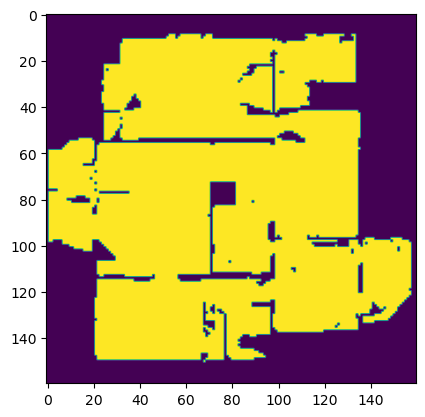

In [4]:
# Assuming mask is of shape (100, X, Y, Z) and goalpositions is generated for 100 samples
samuelsmask = maps[100,:,:,:]
samuelsmask_array = np.repeat(samuelsmask[np.newaxis, :, :, :], 100, axis=0)
plt.imshow(samuelsmask[:,:,30])


In [5]:


# Generate random positions (assumed to return a 100x3 array for 100 goal positions)
goalpositions = generaterandompos(samuelsmask_array)

val_PNO_array = []
val_FMM_array = []

# Loop through the 100 masks and goal positions
for i in range(100):
    val_PNO, _ = getPNOVal(goalpositions[i, :], samuelsmask_array[i], model)
    val_FMM,_ = getFMMVal(goalpositions[i, :], samuelsmask_array[i])
    val_PNO_array.append(val_PNO)
    val_FMM_array.append(val_FMM)

# Convert the list to a NumPy array for easier manipulation
val_PNO_array = np.array(val_PNO_array)
val_FMM_array = np.array(val_FMM_array)


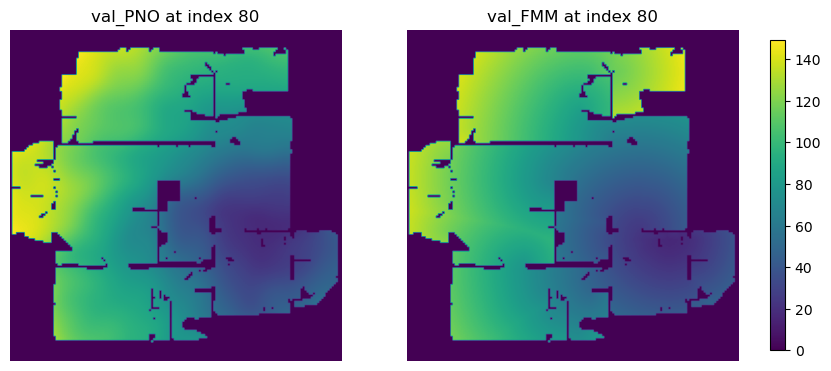

In [12]:
index = 80  # Replace with the desired index

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot val_PNO_array
im1 = axes[0].imshow(val_PNO_array[index,:,:,31], cmap='viridis')
axes[0].set_title(f'val_PNO at index {index}')
axes[0].axis('off')  # Remove axis ticks

# Plot val_FMM_array
im2 = axes[1].imshow(val_FMM_array[index,:,:,31], cmap='viridis')
axes[1].set_title(f'val_FMM at index {index}')
axes[1].axis('off')  # Remove axis ticks

# Create a common colorbar
cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()



Save Files

In [13]:
np.save("val_PNO_array_samuels.npy",val_PNO_array)
np.save("val_FMM_array_samuels.npy",val_FMM_array)
np.save("goal_samuels.npy",goalpositions)
